In [58]:
# The MIT License (MIT) Copyright (c) 2023 Emilio Morales
#
# Permission is hereby granted, free of charge, to any person obtaining a copy of
# this software and associated documentation files (the "Software"), to deal in the Software without
# restriction, including without limitation the rights to use, copy, modify, merge, publish,
# distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in all copies or
# substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED,
# INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND
# NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES
# OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
# CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/Andrea585976/ArtEmis-ProyectoPLN/blob/main/models/artemis_bert.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
</table>

# Image Captioning Transformer

- This notebook explores the combination of Transformers and CNNs for image captioning, showcasing their remarkable ability to generate descriptive textual captions based on visual content.

In [59]:
#!pip install transformers

In [60]:
import torch
import torchvision
import PIL
import pathlib
import random
from transformers import DistilBertTokenizer, DistilBertModel
torch.__version__

'2.2.1+cu121'

In [61]:
torch.manual_seed(77)

## 1.- Dataset

In [62]:
# Download dataset
if not os.path.exists('img.zip'):
  !wget https://github.com/Andrea585976/ArtEmis-ProyectoPLN/raw/main/img.zip
  !unzip img.zip
  !rm img.zip
if not os.path.exists('romanticism_dataset.csv'):
  !wget https://raw.githubusercontent.com/Andrea585976/ArtEmis-ProyectoPLN/main/romanticism_dataset.csv


--2024-05-21 05:33:49--  https://raw.githubusercontent.com/Andrea585976/ArtEmis-ProyectoPLN/main/romanticism_dataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5594530 (5.3M) [text/plain]
Saving to: ‘romanticism_dataset.csv’

romanticism_dataset 100%[===================>]   5.33M  --.-KB/s    in 0.04s   

2024-05-21 05:33:49 (142 MB/s) - ‘romanticism_dataset.csv’ saved [5594530/5594530]



In [63]:
import pandas as pd

# Cargar el archivo CSV en un DataFrame de pandas
df = pd.read_csv('/content/drive/MyDrive/artemis/romanticism_dataset.csv')
print(df.columns)

images = df.loc[:, ['painting', 'utterance']]

#images.head(10)
images['painting'] = images['painting'].apply(lambda x: './img/' + x + '.jpg')

images.head(10)

Index(['painting', 'emotion', 'utterance', 'repetition'], dtype='object')


,painting,utterance
0,./img/viktor-vasnetsov_ivan-tsarevich-riding-t...,The scene is quite beautiful and reminds me of...
1,./img/viktor-vasnetsov_ivan-tsarevich-riding-t...,There is a sense of romance between the two pe...
2,./img/william-turner_fishermen-at-sea.jpg,"There is a spooky feel to this image, with the..."
3,./img/william-turner_fishermen-at-sea.jpg,The boat makes a dangerous journey alone at ni...
4,./img/paul-cezanne_the-oilmill-1871.jpg,The village looks very rudimentary with it's s...
5,./img/n.c.-wyeth_merlin-taking-away-the-infant...,It looks like the baby is being taken for what...
6,./img/orest-kiprensky_the-family-of-satyrs.jpg,The imps playfully dance and sing to the music.
7,./img/sir-lawrence-alma-tadema_strigils-and-sp...,The women appear quite interested in one anoth...
8,./img/orest-kiprensky_putto-with-a-globe.jpg,The little boy is trying to roll the globe aro...
9,./img/sir-lawrence-alma-tadema_pleading-1876.jpg,The man laying down in this painting feels lik...


- Download images:

In [64]:

import numpy as np

# Convertir df_subset en un arreglo NumPy sin nombres de columnas
images = images.values
len(images)

39069

- Dataset split

In [65]:
random.Random(77).shuffle(images)

num_val_samples = int(0.05 * len(images))
train_images = images[num_val_samples:]
val_images= images[:num_val_samples]
len(train_images), len(val_images)

(37116, 1953)

In [66]:
import os

def generate_tuples(paths):
    tuples = []
    for image_path, text in paths:
        if os.path.exists(image_path):  # Verificar si la imagen existe en la ruta
            tuples.append((image_path, text.strip()))
    return tuples

train_tuples = generate_tuples(train_images)
val_tuples = generate_tuples(val_images)

len(train_tuples), len(val_tuples)

(36732, 1953)

In [67]:
for tuple in train_tuples[:2]:
    print(tuple)

('./img/gustave-dore_samson-carries-away-the-gates-of-gaza.jpg', 'The dark painting is far from my favorite, but the animal by the ocean is still a beautiful scene.')
('./img/gustave-dore_the-inferno-canto-12-2.jpg', 'The black and grey colors combined with the violent figures')


## 2.- Pipeline

- Create vocabulary and tokenizer.

In [68]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import vocab as Vocab
from collections import Counter

In [69]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)
bert_model = DistilBertModel.from_pretrained('distilbert-base-uncased')

In [70]:
vocab_size = tokenizer.vocab_size
vocab_size

30522

In [71]:
image_size = 128
batch_size = 64
maxlen = 36


- Reduce dataset size for simplicity

In [72]:
def data_process(text, tokenizer, maxlen):
    data = []
    for x, y in text:
        tensor_ = torch.tensor(
            tokenizer.encode(y, truncation=True, padding='max_length', max_length=maxlen, add_special_tokens=True),
            dtype=torch.long
        )
        data.append((x, tensor_))
    return data

# Procesar datos
image_size = 128
batch_size = 64
maxlen = 36

train_data = data_process(train_tuples[:50000], tokenizer, maxlen)
val_data = data_process(val_tuples[:1000], tokenizer, maxlen)
len(train_data), len(val_data)

(36732, 1000)

In [73]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.nn.utils.rnn import pad_sequence
from PIL import Image

transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor()
])

def generate_batch(data_batch):
    x, y = [], []
    for (x_item, y_item) in data_batch:
        image = Image.open(x_item).convert('RGB')
        image = transform(image)
        x.append(image)
        y.append(y_item)
    x = torch.stack(x)
    y = pad_sequence(y, batch_first=True, padding_value=tokenizer.pad_token_id)
    return x, y[:, :-1], y[:, 1:]


train_loader = DataLoader(train_data, batch_size=batch_size,
                    shuffle=True, collate_fn=generate_batch,
                    num_workers=4, pin_memory=True)

val_loader = DataLoader(val_data, batch_size=batch_size,
                    shuffle=False, collate_fn=generate_batch,
                    num_workers=4, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [74]:
enc_batch, dec_batch, target_batch = next(iter(val_loader))
enc_batch.shape, dec_batch.shape, target_batch.shape

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


(torch.Size([64, 3, 128, 128]), torch.Size([64, 35]), torch.Size([64, 35]))

In [75]:
import matplotlib.pyplot as plt

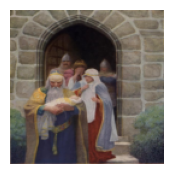

Ground truth: it looks like the baby is being taken for whatever reason but you can see solemn faces and a woman crying.


In [76]:
def plot_img(img, target):
    image_array = img.permute(1, 2, 0).numpy()
    # Decodificar los tokens usando el tokenizador de BERT
    target_text = tokenizer.decode(target.tolist(), skip_special_tokens=True)

    fig = plt.figure(figsize=(2, 2))

    # Mostrar la imagen
    plt.imshow(image_array)
    plt.axis('off')  # Opcional: Ocultar los ejes
    plt.show()
    print(f'Ground truth: {target_text}')

idx = 10
plot_img(enc_batch[idx], target_batch[idx])

## 3.- Model

### Feature extraction block
- Define a convolutional network for image feature extraction.

In [77]:
import torch.nn as nn
from torch import optim
import time

In [78]:
class DownBlockComp(nn.Module):
    def __init__(self, in_planes, out_planes):
        super(DownBlockComp, self).__init__()

        self.main = nn.Sequential(
            nn.Conv2d(in_planes, out_planes, 3, 2, 1, bias=False),
            nn.BatchNorm2d(out_planes), nn.LeakyReLU(0.2, inplace=True),
        )

        self.direct = nn.Sequential(
            nn.AvgPool2d(2, 2),
            nn.Conv2d(in_planes, out_planes, 1, 1, 0, bias=False),
            nn.BatchNorm2d(out_planes), nn.LeakyReLU(0.2, inplace=True))

    def forward(self, feat):
        return (self.main(feat) + self.direct(feat)) / 2

In [79]:
class CNN(nn.Module):
    def __init__(self, filters=128):
        super(CNN, self).__init__()
        self.filters = filters
        self.down_block = nn.Sequential(
            nn.Conv2d(3, filters // 8, 3, 1, 1, bias=False),
            nn.BatchNorm2d(filters // 8), nn.LeakyReLU(0.2, inplace=True),
            DownBlockComp(filters // 8, filters // 4),
            DownBlockComp(filters // 4, filters // 2),
            DownBlockComp(filters // 2, filters),
            DownBlockComp(filters, filters),
            nn.Conv2d(filters, filters, 3, 1, 0, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self, x):
        B = x.shape[0]
        x = self.down_block(x)
        x = torch.permute(x, [0, 2, 3, 1]).view(B, -1, self.filters)
        return x


discriminator = CNN(256)
out_disc = discriminator(enc_batch)
out_disc.shape

torch.Size([64, 36, 256])

### Transformer block

In [80]:
class Attention(nn.Module):
    def __init__(self, dim, maxlen, n_heads=4, bias=True):
        super().__init__()
        self.n_heads = n_heads
        self.scale = (dim // n_heads) ** -0.5
        self.wq = nn.Linear(dim, dim, bias = bias)
        self.wk = nn.Linear(dim, dim, bias = bias)
        self.wv = nn.Linear(dim, dim, bias = bias)

        self.wo = nn.Linear(dim, dim, bias = bias)
        self.register_buffer("bias", torch.tril(torch.ones(maxlen, maxlen)).view(1, 1, maxlen, maxlen))

    def forward(self, x, context=None):
        B, L, D = x.shape
        out_L = L
        q = self.wq(x)
        q = torch.reshape(q, [B, L, self.n_heads, -1])
        q = torch.permute(q, [0, 2, 1, 3])

        if context == None:
            k = self.wk(x)
            v = self.wv(x)
        else:
            k = self.wk(context)
            v = self.wv(context)
            B, L, D = k.shape

        k = torch.reshape(k, [B, L, self.n_heads, -1])
        k = torch.permute(k, [0, 2, 3, 1])
        v = torch.reshape(v, [B, L, self.n_heads, -1])
        v = torch.permute(v, [0, 2, 1, 3])

        qk = torch.matmul(q, k) * self.scale
        if context == None:
            qk = qk.masked_fill(self.bias[:,:,:L,:L] == 0, float('-inf'))

        attn = torch.softmax(qk, dim=-1)

        v_attn = torch.matmul(attn, v)
        v_attn = torch.permute(v_attn, [0, 2, 1, 3])
        v_attn = torch.reshape(v_attn, [B, out_L, D])

        x = self.wo(v_attn)
        return x


q_test = torch.ones([1, 8, 32])
k_test = torch.ones([1, 64, 32])
test_layer = Attention(32, maxlen, n_heads=4)
test_layer(q_test).shape, test_layer(q_test, k_test).shape

(torch.Size([1, 8, 32]), torch.Size([1, 8, 32]))

- Define Transformer:

In [81]:
class DecoderBlock(nn.Module):
    def __init__(self, dim, maxlen, heads=4, mlp_dim=512, rate=0.0):
        super().__init__()
        self.ln_1 = nn.LayerNorm(dim)
        self.attn = Attention(dim, maxlen)
        self.cross_attn = Attention(dim, maxlen)
        self.ln_2 = nn.LayerNorm(dim)
        self.ln_3 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(rate),
            nn.Linear(mlp_dim, dim),
            nn.Dropout(rate),
        )

    def forward(self, x):
        inputs, context = x
        x = self.attn(inputs)
        skip1 = self.ln_1(x + inputs)
        x = self.cross_attn(skip1, context)
        skip2 = self.ln_2(x + skip1)
        return self.ln_3(self.mlp(skip2) + skip2)


test_layer = DecoderBlock(32, maxlen)
x_test = torch.ones([1, maxlen, 32])
test_layer([x_test, x_test]).shape

torch.Size([1, 36, 32])

- Define Transformer

In [82]:
enc_batch.shape, dec_batch.shape, target_batch.shape

(torch.Size([64, 3, 128, 128]), torch.Size([64, 35]), torch.Size([64, 35]))

### Transformer

In [99]:
class Transformer(nn.Module):
    def __init__(self, bert_model, dim, vocab_size, maxlen, depth=3, mlp_dim=512, rate=0.2):
        super().__init__()
        self.depth = depth
        self.bert_model = bert_model
        self.embedding = nn.Embedding(vocab_size, dim)
        self.pos_embedding = nn.Parameter(torch.randn(1, maxlen, dim))
        self.decoder = nn.ModuleList([DecoderBlock(dim, maxlen) for _ in range(self.depth)])
        self.head = nn.Linear(dim, vocab_size, bias=False)
        self.cnn = CNN(dim)

    def forward(self, x, context):
        B, L = x.shape
        x = self.embedding(x)
        x += self.pos_embedding[:, :L]
        context = self.cnn(context)
        for layer in self.decoder:
            x = layer([x, context])
        x = self.head(x)
        return x



device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
transformer = Transformer(bert_model, dim=64, vocab_size=vocab_size, maxlen=maxlen, depth=3, mlp_dim=128)
transformer.to(device)
optimizer = optim.Adam(transformer.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)

## 4.- Training

In [100]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

transformer.to(device)

cuda:0


Transformer(
  (bert_model): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linea

In [101]:
lr = 1e-07

optimizer = optim.Adam(transformer.parameters(), lr=lr)
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)

In [102]:
def train(model, device, train_loader, optimizer, epoch):
    start = time.time()
    running_loss = 0.0
    model.train()
    for inp_enc, inp_dec, tar_dec in train_loader:
        tar_dec = tar_dec.reshape(-1)
        inp_enc = inp_enc.to(device)
        inp_dec = inp_dec.to(device)
        tar_dec = tar_dec.to(device)
        optimizer.zero_grad()
        outputs = model(inp_dec, inp_enc)
        outputs = outputs.view(-1, outputs.size(-1))
        loss = loss_fn(outputs, tar_dec)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'\nTime for epoch {epoch} is {time.time()-start:.4f} sec Train loss: {running_loss / len(train_loader):.4f}')

In [103]:
def generate(model, image, tokenizer, device, maxlen):
    model.eval()
    with torch.no_grad():
        image = image.unsqueeze(0).to(device)
        idx = torch.tensor([tokenizer.cls_token_id], dtype=torch.long).to(device).unsqueeze(0)  # cls_token_id for BOS
        for _ in range(maxlen):
            logits = model(idx, image)[:, -1, :]
            probs = torch.softmax(logits, dim=-1)
            _, idx_next = torch.topk(probs, k=1, dim=-1)
            if idx_next.item() == tokenizer.sep_token_id:  # sep_token_id for EOS
                break
            idx = torch.cat((idx, idx_next), dim=-1)
        txt = tokenizer.decode(idx.squeeze().tolist(), skip_special_tokens=True)
        print(f'Generated text: {txt}')


generate(transformer, enc_batch[idx], tokenizer, device, maxlen)

Generated text: newscasts fronts gamma leverageoides communicate stylistic nile delhi tales व 53hol conductedringtonᄌ streak trumpetaceous located remotelydhi relate [unused458] indicating م miniature nec 1716 extraordinary threatsrgh nationwide90 crossed unknown


In [104]:
epochs = 6
for epoch in range(epochs):
    train(transformer, device, train_loader, optimizer, epoch)
    generate(transformer, enc_batch[idx], tokenizer, device, maxlen)


Time for epoch 0 is 212.7866 sec Train loss: 10.4845
Generated text: newscasts fronts gamma royce hauling sorbonne soluble 1966 tequila hint irene siena head patrick once blazed 00 threaded empiricalorough ge sawmillenting realise habsburg europe remy appreciate enslaved ে nape ч gettinguto everton keller

Time for epoch 1 is 208.1908 sec Train loss: 10.4711
Generated text: newscasts fronts gamma royce hauling sorbonne soluble 1966 tequila hint irene siena head akron 太 angola streak trumpetaceous xiao promptlyuca rolls cab maximum villaitunglby laguna ousted judgments touchdown rack iphone chemist peered

Time for epoch 2 is 208.5850 sec Train loss: 10.4577
Generated text: newscasts fronts gamma royce hauling sorbonne soluble 1966 tequila hint irene siena head akron neighborhoods play ংnessy lowland distinguishing liquoruca tracts continents lawful seminole racist windsher penitentiary intellectual desert semantics breaking infancy capcom

Time for epoch 3 is 205.5661 sec Train loss: 

- Test the model on validation images.

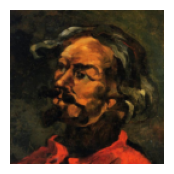

Ground truth: the mans facial hair looks goofy and the shape and texture of his face looks almost lumpy and unrealistic.
Generated text: groups 316 benin ظulla kilometres machmann grazed taboo hunts indigo trance frontsquet ोwearcoll bitch doping oral sandals taxis picassoeo exploded simpsons overcome general noticing robbersworkslandabble tapestry trondheim


In [105]:
idx = 47
plot_img(enc_batch[idx], target_batch[idx])
generate(transformer, enc_batch[idx], tokenizer, device, maxlen)

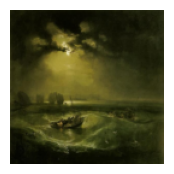

Ground truth: there is a spooky feel to this image, with the waters churning and the green sky overhead.
Generated text: groups 316 benin ظulla kilometres machmann grazed taboo hunts indigo trance frontsquet ोwearcoll bitch doping oral sandals taxis picassoeo exploded simpsons overcome general noticing robbersworkslandabble tapestry trondheim


In [106]:
idx = 60
plot_img(enc_batch[idx], target_batch[idx])
generate(transformer, enc_batch[idx], tokenizer, device, maxlen)

In [107]:
idx = 81
plot_img(enc_batch[idx], target_batch[idx])
generate(transformer, enc_batch[idx], tokenizer, device, maxlen)

IndexError: index 81 is out of bounds for dimension 0 with size 64